In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('IBM CLV.csv')
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [3]:
df.isna().sum()

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

In [4]:
df.shape

(9134, 24)

In [5]:
df.drop_duplicates().shape

(9134, 24)

In [6]:
df.dtypes

Customer                          object
State                             object
Customer Lifetime Value          float64
Response                          object
Coverage                          object
Education                         object
Effective To Date                 object
EmploymentStatus                  object
Gender                            object
Income                             int64
Location Code                     object
Marital Status                    object
Monthly Premium Auto               int64
Months Since Last Claim            int64
Months Since Policy Inception      int64
Number of Open Complaints          int64
Number of Policies                 int64
Policy Type                       object
Policy                            object
Renew Offer Type                  object
Sales Channel                     object
Total Claim Amount               float64
Vehicle Class                     object
Vehicle Size                      object
dtype: object

In [7]:
df['Effective To Date'] = pd.to_datetime(df['Effective To Date'])
df['Effective To Date']

0      2011-02-24
1      2011-01-31
2      2011-02-19
3      2011-01-20
4      2011-02-03
          ...    
9129   2011-02-10
9130   2011-02-12
9131   2011-02-06
9132   2011-02-03
9133   2011-02-14
Name: Effective To Date, Length: 9134, dtype: datetime64[ns]

In [8]:
values_to_replace = df.Education.replace(to_replace=['College','Master','Doctor','Bachelor'], value='Bachelor or Above')
df.Education = values_to_replace
df.Education.value_counts()

Bachelor or Above       6512
High School or Below    2622
Name: Education, dtype: int64

<AxesSubplot:>

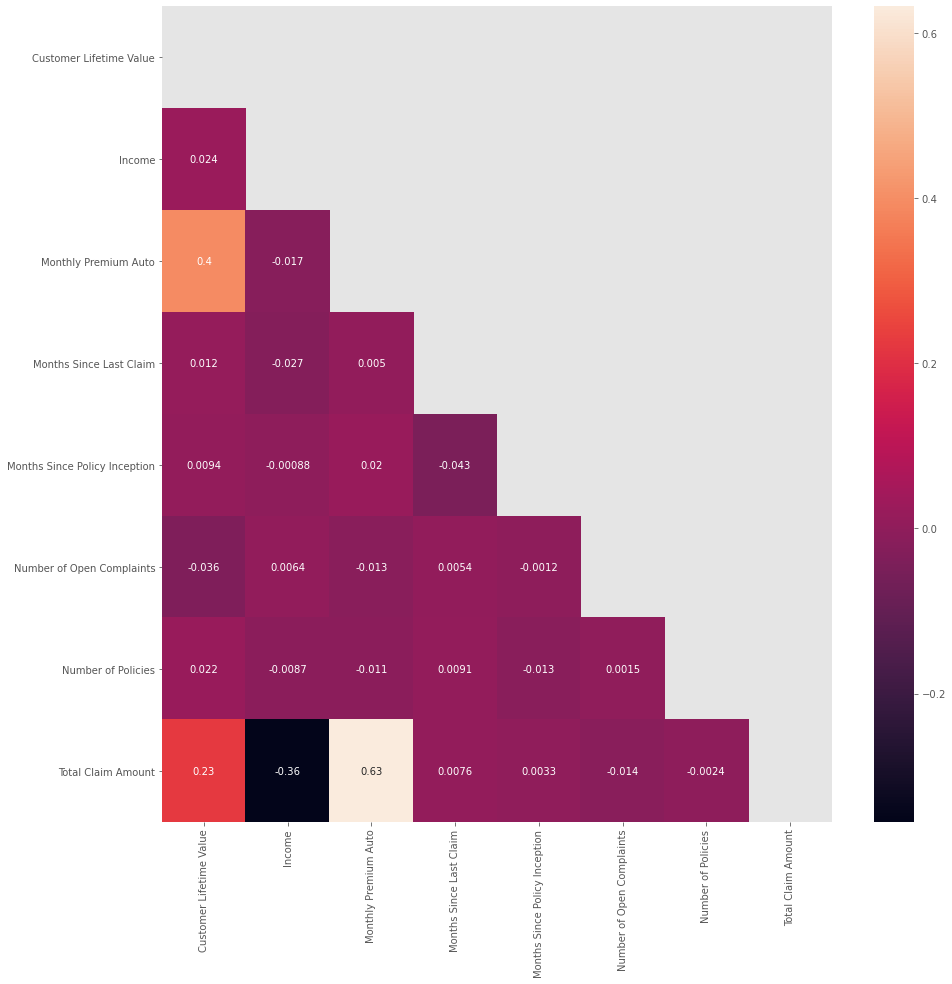

In [9]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,15))
sns.heatmap(corr,annot=True,mask=mask)

In [10]:
X = df.drop(['Customer Lifetime Value', #Target variable
             'Monthly Premium Auto', #Contributes heavily to target variable
             'Total Claim Amount', #Contributes heavily to target variable
             'Customer', #Unique ID
             'Number of Policies', #Contributes heavily to target variable
             'Effective To Date', #Gave model problems
             'EmploymentStatus', #Information found in 'Income' column
            'Location Code',
            'Policy Type',
            'Policy',
            'Renew Offer Type',
            'Response',
            'Coverage',
            'Months Since Last Claim',
            'Months Since Policy Inception',
            'Number of Open Complaints',
            'Sales Channel'],axis=1) #Information found in 'State' coumn
y = df['Customer Lifetime Value']

In [45]:
column_dict = dict(X.dtypes)
encode_list = []
for key in column_dict:
     if column_dict[key] == np.dtype('O'):
            encode_list.append(key)
encode_list

['State',
 'Education',
 'Gender',
 'Marital Status',
 'Vehicle Class',
 'Vehicle Size']

In [46]:
for column in encode_list:
    print(column)
    print(df[column].value_counts())

State
California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: State, dtype: int64
Education
Bachelor or Above       6512
High School or Below    2622
Name: Education, dtype: int64
Gender
F    4658
M    4476
Name: Gender, dtype: int64
Marital Status
Married     5298
Single      2467
Divorced    1369
Name: Marital Status, dtype: int64
Vehicle Class
Four-Door Car    4621
Two-Door Car     1886
SUV              1796
Sports Car        484
Luxury SUV        184
Luxury Car        163
Name: Vehicle Class, dtype: int64
Vehicle Size
Medsize    6424
Small      1764
Large       946
Name: Vehicle Size, dtype: int64


In [47]:
ordinal_list = ['Education','Vehicle Size']
encode_list
for column in ordinal_list:
    encode_list.remove(column)

In [48]:
for column in ordinal_list:
    print(column not in encode_list)

True
True


In [49]:
ohe = OneHotEncoder()
ohe.fit_transform(df[encode_list])
ohe.categories_

[array(['Arizona', 'California', 'Nevada', 'Oregon', 'Washington'],
       dtype=object),
 array(['F', 'M'], dtype=object),
 array(['Divorced', 'Married', 'Single'], dtype=object),
 array(['Four-Door Car', 'Luxury Car', 'Luxury SUV', 'SUV', 'Sports Car',
        'Two-Door Car'], dtype=object)]

In [50]:
oe_dict = {}
i = 0
for column in ordinal_list:
    loop_list = []
    for key in dict(X[column].value_counts()):
        loop_list.append(key)
    oe_dict[i] = loop_list
    i = i + 1
oe_dict

{0: ['Bachelor or Above', 'High School or Below'],
 1: ['Medsize', 'Small', 'Large']}

In [51]:
oe_dict[0] = ['High School or Below','Bachelor or Above']
oe_dict[1] = ['Small', 'Medsize','Large']

In [52]:
ordinal_list

['Education', 'Vehicle Size']

In [53]:
oe = OrdinalEncoder(categories=[oe_dict[0],oe_dict[1]])
oe.fit_transform(X[ordinal_list])
oe.categories_

[array(['High School or Below', 'Bachelor or Above'], dtype=object),
 array(['Small', 'Medsize', 'Large'], dtype=object)]

In [28]:
column_trans = make_column_transformer((OneHotEncoder(),encode_list),
                                      (OrdinalEncoder(categories=[oe_dict[0],
                                                                  oe_dict[1]]),
                                      ordinal_list),remainder='drop')
column_trans.fit_transform(X)

array([[0., 0., 0., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 1., 2.],
       [0., 1., 0., ..., 1., 1., 1.]])

In [66]:
regr = LinearRegression()
pipe = make_pipeline(column_trans,regr)
pipe.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['State', 'Gender',
                                                   'Marital Status',
                                                   'Vehicle Class']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['High '
                                                                              'School '
                                                                              'or '
                                                                              'Below',
                                                                              'Bachelor '
                                                                              'or '
                                

Scoring parameter can be taken from here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [118]:
cross_val_score(pipe,X,y,cv=5,scoring='r2').mean()

0.12081469383072126

In [56]:
X.columns

Index(['State', 'Education', 'Gender', 'Income', 'Marital Status',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [178]:
test_data = pd.read_csv("CLV_test_data.csv")
test_data

,State,Education,Gender,Income,Marital Status,Vehicle Class,Vehicle Size
0,Oregon,Bachelor or Above,M,200000,Single,Luxury SUV,Large
1,Oregon,Bachelor or Above,F,100000,Single,SUV,Large


In [130]:
employed_pipe.predict(test_data)

array([8964., 8964.])

In [110]:
df2 = pd.read_csv('IBM CLV.csv')
df_employed, df_unemployed = df2[df2.Income > 0], df2[df2.Income == 0]

In [114]:
def get_column_trans(X):
    oe = OrdinalEncoder(categories=[oe_dict[0],oe_dict[1]])
    oe.fit_transform(X[ordinal_list])
    ohe = OneHotEncoder()
    ohe.fit_transform(X[encode_list])
    column_trans = make_column_transformer((OneHotEncoder(),encode_list),
                                      (OrdinalEncoder(categories=[oe_dict[0],
                                                                  oe_dict[1]]),
                                      ordinal_list),remainder='drop')
    column_trans.fit_transform(X)
    return column_trans

def get_pipeline(model,column_trans):
    pipe = make_pipeline(column_trans,model)
    return pipe

def drop_columns(df):
    
    values_to_replace = df.Education.replace(to_replace=['College','Master','Doctor','Bachelor'], value='Bachelor or Above')
    df.Education = values_to_replace
    return df.drop(['Customer Lifetime Value', #Target variable
             'Monthly Premium Auto', #Contributes heavily to target variable
             'Total Claim Amount', #Contributes heavily to target variable
             'Customer', #Unique ID
             'Number of Policies', #Contributes heavily to target variable
             'Effective To Date', #Gave model problems
             'EmploymentStatus', #Information found in 'Income' column
            'Location Code',
            'Policy Type',
            'Policy',
            'Renew Offer Type',
            'Response',
            'Coverage',
            'Months Since Last Claim',
            'Months Since Policy Inception',
            'Number of Open Complaints',
            'Sales Channel'],axis=1) #Information found in 'State' coumn

In [115]:
y_employed = df_employed['Customer Lifetime Value']
X_employed = drop_columns(df_employed)

C:\Users\ryan\anaconda3\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,State,Education,Gender,Income,Marital Status,Vehicle Class,Vehicle Size
0,Washington,Bachelor or Above,F,56274,Married,Two-Door Car,Medsize
2,Nevada,Bachelor or Above,F,48767,Married,Two-Door Car,Medsize
4,Washington,Bachelor or Above,M,43836,Single,Four-Door Car,Medsize
5,Oregon,Bachelor or Above,F,62902,Married,Two-Door Car,Medsize
6,Oregon,Bachelor or Above,F,55350,Married,Four-Door Car,Medsize
...,...,...,...,...,...,...,...
9127,California,Bachelor or Above,M,66367,Divorced,Two-Door Car,Small
9128,California,Bachelor or Above,F,47761,Single,Four-Door Car,Large
9129,California,Bachelor or Above,M,71941,Married,Four-Door Car,Medsize
9130,California,Bachelor or Above,F,21604,Divorced,Four-Door Car,Medsize


In [117]:
y_employed = df_employed['Customer Lifetime Value']
X_employed = drop_columns(df_employed)
employed_col_trans = get_column_trans(X_employed)
employed_pipe = get_pipeline(regr,employed_col_trans)
employed_pipe.fit(X_employed,y_employed)
cross_val_score(pipe,X_employed,y_employed,cv=5,scoring='r2').mean()

0.12418511086681164

In [127]:
y_unemployed = df_unemployed['Customer Lifetime Value']
X_unemployed = df_unemployed.drop(['Customer Lifetime Value','Income'],axis=1)
X_unemployed = drop_columns(df_unemployed)
unemployed_col_trans = get_column_trans(X_unemployed)
unemployed_pipe = get_pipeline(regr,unemployed_col_trans)
unemployed_pipe.fit(X_unemployed,y_unemployed)
cross_val_score(pipe,X_unemployed,y_unemployed,cv=5,scoring='r2')

C:\Users\ryan\anaconda3\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


array([-0.00217019,  0.1124502 ,  0.12086005,  0.11036444,  0.11161649])

<AxesSubplot:>

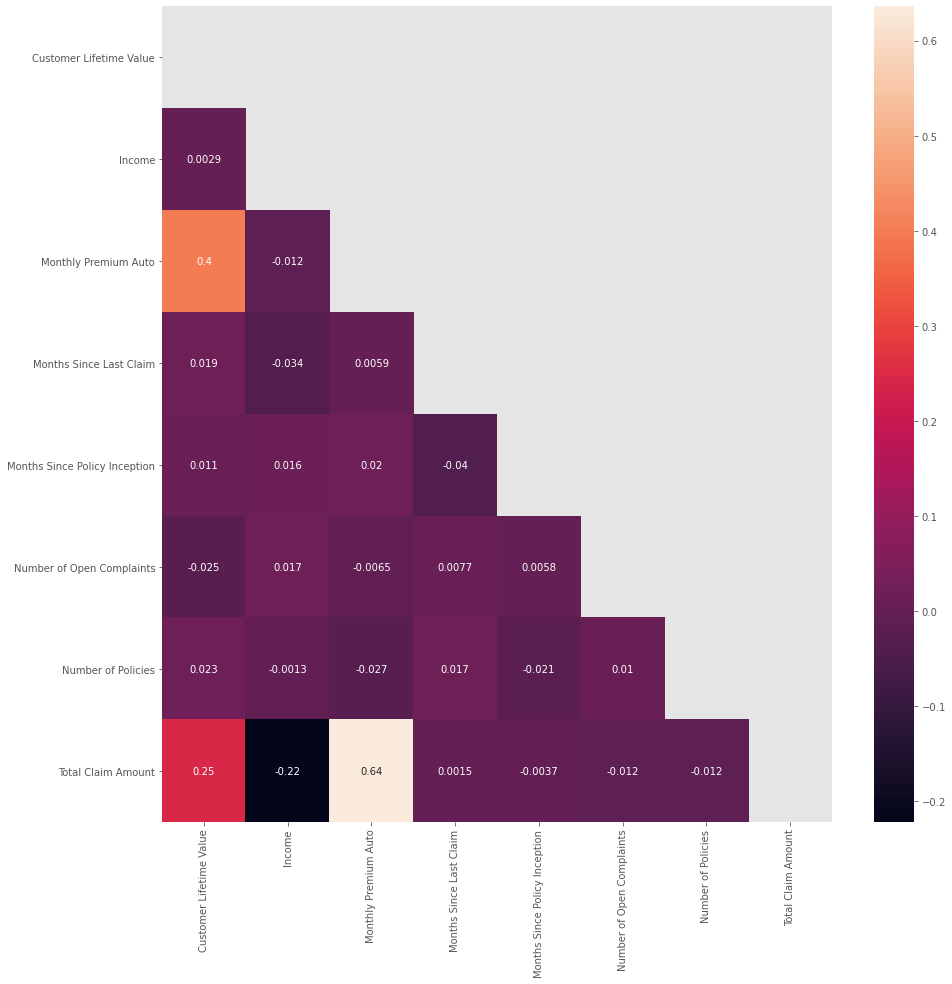

In [132]:
corr = df_employed.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,15))
sns.heatmap(corr,annot=True,mask=mask)

In [149]:
len(lasso_alphas)

200

In [181]:
las = Lasso()
lasso_alphas = np.logspace(-6, 6, 20)
coefs_las = []
r2_las = []
prediction = []
for a in lasso_alphas:
    las.set_params(alpha = a)
    pipe_las = make_pipeline(column_trans,las)
    pipe_las.fit(X,y)
    result = cross_val_score(pipe_las,X,y,cv=5,scoring='r2').mean()
    r2_las.append(result)
    coefs_las.append(a)
    prediction.append(pipe_las.predict(test_data))
    
r2_coef_las = zip(r2_las,coefs_las)

C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68132350499.374756, tolerance: 43117071.892719924
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55345775753.997574, tolerance: 35326664.40313652
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55794689645.44473, tolerance: 35397107.82018515
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51119173532.2124, tolerance: 32311487.450400062
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54793097574.175415, tolerance: 34932195.805535264
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68132553766.75827, tolerance: 43117071.892719924
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

In [171]:
for element in r2_coef_las:
    print(element)

(-0.40297019368307296, 1e-06)
(-0.40297019395208994, 4.281332398719396e-06)
(-0.4029701951038411, 1.8329807108324375e-05)
(-0.4029702000348777, 7.847599703514606e-05)
(-0.40297022114641257, 0.0003359818286283781)
(-0.40297031556628105, 0.0014384498882876629)
(-0.4029707068835453, 0.00615848211066026)
(-0.4029725313090656, 0.026366508987303555)
(-0.4029802999362291, 0.11288378916846883)
(-0.4029907186214582, 0.4832930238571752)
(-0.403063929911957, 2.06913808111479)
(-0.4034523640447028, 8.858667904100814)
(-0.40627194019026563, 37.92690190732246)
(-0.4258556244539083, 162.37767391887175)
(-0.4827184542116137, 695.1927961775591)
(-0.48342979444152456, 2976.3514416313133)
(-0.48342979444152456, 12742.749857031322)
(-0.48342979444152456, 54555.947811685146)
(-0.48342979444152456, 233572.14690901214)
(-0.48342979444152456, 1000000.0)


In [166]:
ridge = Ridge()
ridge_alphas = np.logspace(-6, 6, 20)
coefs_ridge = []
r2_ridge = []
for a in ridge_alphas:
    ridge.set_params(alpha = a)
    pipe_ridge = make_pipeline(column_trans,las)
    pipe_ridge.fit(X,y)
    result = cross_val_score(pipe_ridge,X,y,cv=5,scoring='r2').mean()
    r2_ridge.append(result)
    coefs_ridge.append(a)
    
r2_coef_ridge = zip(r2_ridge,coefs_ridge)

In [167]:
for element in r2_coef_ridge:
    print(element)

(-0.0007925134935758305, 1e-06)
(-0.0007925134935758305, 4.281332398719396e-06)
(-0.0007925134935758305, 1.8329807108324375e-05)
(-0.0007925134935758305, 7.847599703514606e-05)
(-0.0007925134935758305, 0.0003359818286283781)
(-0.0007925134935758305, 0.0014384498882876629)
(-0.0007925134935758305, 0.00615848211066026)
(-0.0007925134935758305, 0.026366508987303555)
(-0.0007925134935758305, 0.11288378916846883)
(-0.0007925134935758305, 0.4832930238571752)
(-0.0007925134935758305, 2.06913808111479)
(-0.0007925134935758305, 8.858667904100814)
(-0.0007925134935758305, 37.92690190732246)
(-0.0007925134935758305, 162.37767391887175)
(-0.0007925134935758305, 695.1927961775591)
(-0.0007925134935758305, 2976.3514416313133)
(-0.0007925134935758305, 12742.749857031322)
(-0.0007925134935758305, 54555.947811685146)
(-0.0007925134935758305, 233572.14690901214)
(-0.0007925134935758305, 1000000.0)


In [190]:
las.set_params(alpha = 8.858667904100814)
pipe_las = make_pipeline(column_trans,las)
pipe_las.fit(X,y)
pipe_las.predict(test_data)

array([15991.91907324, 10011.81559678])

In [191]:
for i in prediction:
    print(i)

[16352.95461088  9926.2649037 ]
[16352.95450379  9926.26492654]
[16352.95404532  9926.26502435]
[16352.95208243  9926.2654431 ]
[16352.94367864  9926.26723589]
[16352.89868758  9926.26557289]
[16352.71507756  9926.26779158]
[16351.93538884  9926.28214343]
[16348.6171626  9926.335064 ]
[16333.04626686  9930.71388913]
[16267.73103784  9945.27467658]
[15991.91907324 10011.81559678]
[14882.59883669 10238.38023939]
[10248.92857717 10248.92857717]
[8004.94047499 8004.94047499]
[8004.94047499 8004.94047499]
[8004.94047499 8004.94047499]
[8004.94047499 8004.94047499]
[8004.94047499 8004.94047499]
[8004.94047499 8004.94047499]
